In [10]:
# 加载相关库
import os
import random
import paddle
import numpy as np
from PIL import Image
import gzip
import json


# 定义数据集读取器
def load_data(mode='train'):

    # 读取数据文件
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    # 读取数据集中的训练集，验证集和测试集
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28
    # 根据输入mode参数决定使用训练集，验证集还是测试
    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]
    # 获得所有图像的数量
    imgs_length = len(imgs)
    # 验证图像数量和标签数量是否一致
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    index_list = list(range(imgs_length))

    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        # 训练模式下，打乱训练数据
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        # 按照索引读取数据
        for i in index_list:
            # 读取图像和标签，转换其尺寸和类型
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('int64')
            imgs_list.append(img) 
            labels_list.append(label)
            # 如果当前数据缓存达到了batch size，就返回一个批次数据
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据缓存列表
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator


In [12]:
# 定义模型结构
import paddle.nn.functional as F
from paddle.nn import Conv2D, MaxPool2D, Linear

# 多层卷积神经网络实现

class MNIST(paddle.nn.Layer):
     def __init__(self):
         super(MNIST, self).__init__()
         
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool1 = MaxPool2D(kernel_size=2, stride=2)
         # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
         self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
         # 定义池化层，池化核的大小kernel_size为2，池化步长为2
         self.max_pool2 = MaxPool2D(kernel_size=2, stride=2)
         # 定义一层全连接层，输出维度是10
         self.fc = Linear(in_features=980, out_features=10)
         
   # 定义网络前向计算过程，卷积后紧接着使用池化层，最后使用全连接层计算最终输出
   # 卷积层激活函数使用Relu，全连接层激活函数使用softmax
     def forward(self, inputs, label):
         x = self.conv1(inputs)
         x = F.sigmoid(x)
         x = self.max_pool1(x)
         x = self.conv2(x)
         x = F.sigmoid(x)
         x = self.max_pool2(x)
         x = paddle.reshape(x, [x.shape[0], 980])
         x = self.fc(x)
         x = F.softmax(x)
         if label is not None:
             acc = paddle.metric.accuracy(input=x, label=label)
             return x, acc
         else:
             return x

#调用加载数据的函数
train_loader = load_data('train')
    
#在使用GPU机器时，可以将use_gpu变量设置成True
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')


loading mnist dataset from ./work/mnist.json.gz ......


CUDAPlace(0)

In [13]:
#引入matplotlib库
import matplotlib.pyplot as plt

def train(model):
    model.train()
    
    opt = paddle.optimizer.Adam(learning_rate=0.001, weight_decay=paddle.regularizer.L2Decay(coeff=1e-5), parameters=model.parameters())
    
    EPOCH_NUM = 10
    iter=0
    iters=[]
    losses=[]
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            #前向计算的过程，同时拿到模型输出值和分类准确率
            predicts, acc = model(images, labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                iters.append(iter)
                losses.append(avg_loss.numpy())
                iter = iter + 100
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    
    return iters, losses
    
model = MNIST()
iters, losses = train(model)

epoch: 0, batch: 0, loss is: [2.2975795], acc is [0.13]
epoch: 0, batch: 100, loss is: [2.2013388], acc is [0.22]
epoch: 0, batch: 200, loss is: [1.9044862], acc is [0.59]
epoch: 0, batch: 300, loss is: [1.7285492], acc is [0.75]
epoch: 0, batch: 400, loss is: [1.6846969], acc is [0.82]
epoch: 1, batch: 0, loss is: [1.6494402], acc is [0.84]
epoch: 1, batch: 100, loss is: [1.5629656], acc is [0.92]
epoch: 1, batch: 200, loss is: [1.6041759], acc is [0.87]
epoch: 1, batch: 300, loss is: [1.5793179], acc is [0.88]
epoch: 1, batch: 400, loss is: [1.5325226], acc is [0.95]
epoch: 2, batch: 0, loss is: [1.5416331], acc is [0.94]
epoch: 2, batch: 100, loss is: [1.5510164], acc is [0.92]
epoch: 2, batch: 200, loss is: [1.5209824], acc is [0.94]
epoch: 2, batch: 300, loss is: [1.4951781], acc is [0.98]
epoch: 2, batch: 400, loss is: [1.5101713], acc is [0.98]
epoch: 3, batch: 0, loss is: [1.4907187], acc is [0.99]
epoch: 3, batch: 100, loss is: [1.5051448], acc is [0.95]
epoch: 3, batch: 200, 

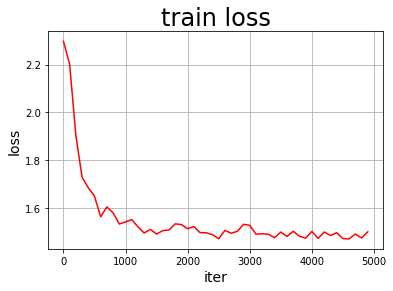

In [14]:
#画出训练过程中Loss的变化曲线
plt.figure()
plt.title("train loss", fontsize=24)
plt.xlabel("iter", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.plot(iters, losses,color='red',label='train loss') 
plt.grid()
plt.show()

In [15]:
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = load_data('eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = MNIST()
evaluation(model)

start evaluation .......
loading mnist dataset from ./work/mnist.json.gz ......
loss=1.4814935755729675, acc=0.9837000066041947
